# Image Triangulation

Polygon art is sweet. Python is sweet. Can we combine the two? Yes, we can! 

Here's the idea. We'll

* load some image data;
* construct a Delaunay trinagulation of some appropriately selected points
* compute the average color within each region;
* use these filled triangles to make our new image.

In [1]:
import numpy as np

import scipy as sp
from scipy import signal
from scipy import misc

import random
import bisect

from scipy.spatial import Delaunay

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

Behold: vulpes vulpes. Doesn't the resolution of this beautiful creature hurt your eyes? Mine too. We can change that.

(390, 620, 3)


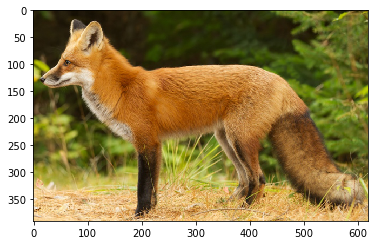

In [2]:
img = sp.misc.imread('fox.jpg')
plt.imshow(img)
shp = img.shape
print(shp)

# Delaunay triangulation

We'll decompose the spatial domain of the image into mutually exclusive triangles using Delaunay triangulation. To do so, we first need to select some (random) collection of points to use as our vertices. We could do this by taking a simple random sample of all the pixel positions in the image, but this might lead to regions that seem strange in the context of the image itself. To make sure that the borders of objects in the image are clearly resolved, we'll instead use a weighted sampling strategy, where the probability of picking a point is proportional to the magnitude of the gradient of the image at that point. 

In [3]:
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

# discrete derviative convolutional matrices
xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

# convolve the image with the derivative matrix, and make the output the same size as the input
dbdx = lambda x: sp.signal.convolve2d(x, xder, mode='same')
dbdy = lambda y: sp.signal.convolve2d(y, yder, mode='same')

grad = np.hypot(dbdx(r), dbdy(r)) + np.hypot(dbdx(g), dbdy(g)) + np.hypot(dbdx(b), dbdy(b))

# we can get poorly behaved numerical gradients at the boundary, so nix them
grad[:,0]  = 0
grad[:,-1] = 0
grad[0,:]  = 0
grad[-1,:] = 0

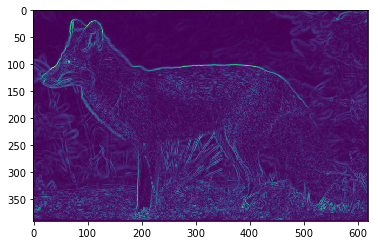

In [4]:
plt.imshow(grad)

In [16]:
# From https://eli.thegreenplace.net/2010/01/22/weighted-random-generation-in-python
class WeightedRandomGenerator(object):
    def __init__(self, weights):
        self.totals = []
        running_total = 0

        for w in weights:
            running_total += w
            self.totals.append(running_total)

    def next(self):
        rnd = random.random() * self.totals[-1]
        return bisect.bisect_right(self.totals, rnd)

    def __call__(self):
        return self.next()
    
## increasing the exponent on the gradient increases the chance that boundaries will be well represented
## note that when the exponent is 0, we're sampling uniformly
gen = WeightedRandomGenerator(grad.reshape((-1,))**1.5)

In [17]:
N = 2000 # number of points to be used in the triangulation
pts = [gen.next() for i in range(N)] 

# this is a little confusing because row <-> y, col <-> x, and imshow puts y=0 at the top
pts = np.array([[pt % shp[1], shp[1] - np.floor(pt/shp[1])] for pt in pts])

Here are the points we've selected. Notice that boundaries in the image are pretty well captured by the points.

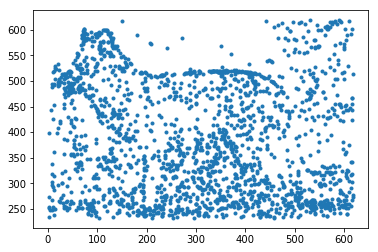

In [18]:
plt.plot(pts[:,0],pts[:,1],'.')

Now let's construct the Delaunay triangulation and see what the regions look like. (Scipy makes this very easy!)

In [19]:
tri = Delaunay(pts)

These regions are kind of a mess! But it'll turn out fine in the end...

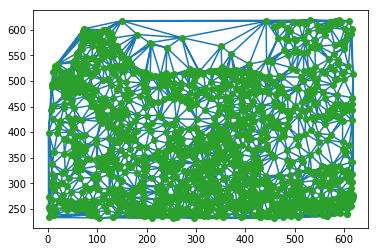

In [20]:
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy())
plt.plot(pts[:,0], pts[:,1], 'o')

We first need to find out which region (AKA simplex) each point in the image belongs to. Some simplices might contain no points, and there will be a simplex labeled -1 marking the exterior of the image. For these reasons, we need to also go through and find a list of the simplex indices that actually get used so that we can assign them colors later.

In [21]:
# again, this is kind of wonky because x <-> col, y <-> row, and imshow puts y=0 at the top.
grd = [(j,shp[1] - i) for i in range(shp[0]) for j in range(shp[1])]
smp = np.array([tri.find_simplex(pt) for pt in grd])
unq = list(set(smp))

Now we'll go through and find the mean color in each region. We'll store these RGB values in a dictionary (keyed by simplex ID) for easy use later.

In [22]:
pts = np.hstack((img.reshape((-1,3)), smp.reshape((-1,1))))
clr = dict([(i, np.array(np.mean(pts[pts[:,-1] == i,:3],axis=0),dtype='uint8')) for i in unq])

To construct the new polygon image, we just need to look up the new color each pixel and then reshape the array to the original image shape.

In [23]:
low = np.array([clr[i] for i in smp]).reshape(shp)

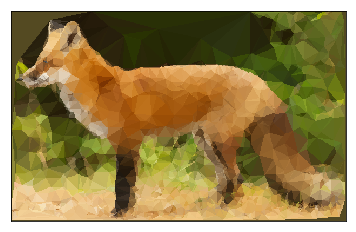

In [24]:
plt.imshow(low)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('low.pdf')